In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date

from sklearn.linear_model import LinearRegression

import pystan

import matplotlib.pyplot as plt

In [2]:
plt.style.context('seaborn')

In [3]:
df = pd.read_csv(
    'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv', 
    header=None, 
    parse_dates=[0], 
    dtype={1: np.float16}, 
    names=['date', 'level_ppm']
)
df.head()

,date,level_ppm
0,1958-03-29,316.25
1,1958-04-05,317.25
2,1958-04-12,317.75
3,1958-04-19,317.50
4,1958-04-26,316.50


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3210 entries, 0 to 3209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3210 non-null   datetime64[ns]
 1   level_ppm  3210 non-null   float16       
dtypes: datetime64[ns](1), float16(1)
memory usage: 31.5 KB


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


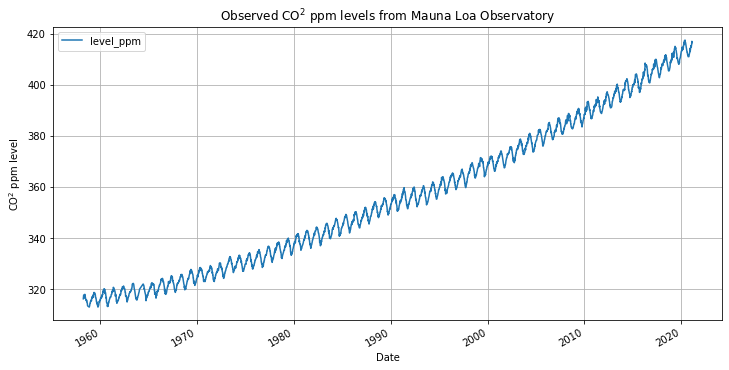

In [5]:
df.plot('date', 'level_ppm', figsize=(12, 6), grid=True)
plt.ylabel('CO$^2$ ppm level')
plt.xlabel('Date')
plt.title('Observed CO$^2$ ppm levels from Mauna Loa Observatory')
plt.savefig('observed_data.png')

In [6]:
df['ordinal'] = df['date'].apply(datetime.toordinal)
df.head()

,date,level_ppm,ordinal
0,1958-03-29,316.25,714867
1,1958-04-05,317.25,714874
2,1958-04-12,317.75,714881
3,1958-04-19,317.50,714888
4,1958-04-26,316.50,714895


In [7]:
last_date = date(2060, 1, 1)
future_dates = pd.date_range(start=max(df['date']),end=last_date).to_series()
future_dates_ordinal = future_dates.apply(datetime.toordinal)
stan_data = {
    'N': len(df),
    'y': df['level_ppm'],
    'x': df['ordinal'],
    'nFutureCount': len(future_dates),
    'futureDays': future_dates_ordinal
}
to_predict_dates = df['date'].append(future_dates)
to_predict = to_predict_dates.apply(datetime.toordinal)

In [8]:
# Generate starting points for the models
lr = LinearRegression(n_jobs=-1)
lr.fit(
    X = df[['ordinal']],
    y = df[['level_ppm']]
)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [9]:
%%time
bad_stan:str = """
data {
    int<lower=1> N;
    vector[N] y;
    vector[N] x;  // Ordinal date
    int<lower=1> nFutureCount;
    vector[nFutureCount] futureDays; // The future days to make predictions for
}

parameters {
    // Linear relationship
    real<lower=-10000, upper=10000>t_intercept;
    real<lower=0, upper=1>t_coef;  // Prior knowledge informs us of increasing c02 levels
    // Seasonal variation
    real<lower=0, upper=5> c2;
    real<lower=-5, upper=5> c3;
    real<lower=0>sigma;  // Standard deviation has to be positive
}

model {
    t_intercept ~ cauchy(-2800, 100);
    t_coef ~ cauchy(0.005, 0.01);
    c2 ~ cauchy(2.5, 1);
    c3 ~ cauchy(0, 1);
    y ~ normal(
        t_intercept + t_coef*x + c2 * cos(2 * pi() * x / 365.25 + c3),
        sigma
    );
}

generated quantities {
   real x_future[nFutureCount];
   for (t in 1:nFutureCount){
       x_future[t] = normal_rng(
           t_intercept + t_coef*(futureDays[t]) + c2 * cos(2 * pi() * (futureDays[t]) / 365.25 + c3),
           sigma
       );
   }
}
"""
bad_stan_model = pystan.StanModel(model_code=bad_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d7456d34a50b8a3ccde1da9f9c09ff9b NOW.


CPU times: user 1.69 s, sys: 149 ms, total: 1.84 s
Wall time: 1min 20s


In [ ]:
%%time
bad_parameters = ['t_intercept', 't_coef', 'c2', 'c3', 'sigma']
bad_results = bad_stan_model.sampling(
    data=stan_data,
    init=[{
        't_intercept': lr.intercept_[0],
        't_coef': lr.coef_[0][0]
    }] * 4
)
print(bad_results.stansummary(pars=bad_parameters))
bad_samples = bad_results.extract()

In [ ]:
def get_parameter(parameter:str, results, func = np.mean) -> float:
    return np.mean(results[parameter])

In [ ]:
# Model parameters
bad_t_intercept = get_parameter('t_intercept', bad_results)
bad_t_coef = get_parameter('t_coef', bad_results)
bad_c2 = get_parameter('c2', bad_results)
bad_c3 = get_parameter('c3', bad_results)

In [ ]:
# Stan model future predictions output
bad_prediction = bad_samples['x_future']

# Compute 95% interval of the predicted values
bad_prediction_interval = np.percentile(bad_prediction, axis=0, q=[2.5, 97.5])

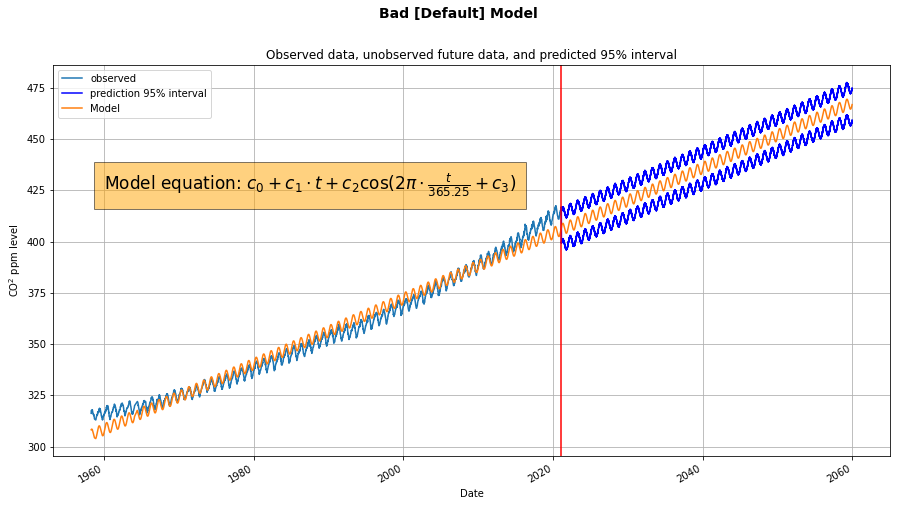

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()

fig.suptitle('Bad [Default] Model', fontsize=14, fontweight='bold')
# Observed data
df.plot('date', 'level_ppm', ax=ax, grid=True, label='observed')

# 95% confidence interval lower and upper bounds
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], bad_prediction_interval[0,1:])),
    'b-', label='prediction 95% interval')
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], bad_prediction_interval[1,1:])),
    'b-')

# Model
model_predictions = bad_c0 + bad_c1* to_predict + bad_c2 * np.cos(2 * np.pi * to_predict / 365.25 + bad_c3)
ax.plot(to_predict_dates, model_predictions, label="Model")

# Last observed date line
ax.axvline(max(df['date']), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('CO$^2$ ppm level')
ax.legend()
ax.set_title('Observed data, unobserved future data, and predicted 95% interval')
ax.text(
    date(1960, 1, 1), 425, 
    r'Model equation: $c_0 + c_1 \cdot t + c_2 \cos(2 \pi \cdot \frac{t}{365.25} + c_3$)', 
    fontsize=17, bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10}
)
plt.savefig('bad_model.png')
plt.show()

In [ ]:
%%time
good_stan_model = pystan.StanModel(file='good_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e4726cce51f40e5fc053276664f79ce8 NOW.


CPU times: user 1.17 s, sys: 77.5 ms, total: 1.25 s
Wall time: 58.8 s


In [ ]:
%%time
good_parameters = ['c0', 'c1', 'c2', 'c3', 'c4', 'sigma']
good_results = good_stan_model.sampling(data=stan_data)
print(good_results.stansummary(pars=good_parameters))
good_samples = good_results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_e4726cce51f40e5fc053276664f79ce8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0     54.39   66.27   95.9   -1.45  -0.54   0.34  32.49 235.19      2   5.68
c1      0.03    0.01   0.02 3.4e-10   0.02   0.04   0.05   0.05      2  23.33
c2      1.76    0.64   0.96    1.23   1.23   1.24   1.37   3.66      2   4.04
c3      2.85  3.7e-3   0.06    2.72   2.81   2.85   2.88   2.98    306   1.01
c4     -1.66  2.6e-3   0.02   -1.71  -1.68  -1.66  -1.65  -1.61     91   1.05
sigma   2.62    0.45   0.67    1.32   2.85   2.97   3.01   3.06      2   4.07

Samples were drawn using NUTS at Thu Apr 22 23:00:38 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 2.7 s, sys: 3.24 s, total:

In [ ]:
# Model parameters
good_c0 = get_parameter('c0', good_results)
good_c1 = get_parameter('c1', good_results)
good_c2 = get_parameter('c2', good_results)
good_c3 = get_parameter('c3', good_results)
good_c4 = get_parameter('c4', good_results)

In [ ]:
# Stan model future predictions output
good_prediction = good_samples['x_future']

# Compute 95% interval of the predicted values
good_prediction_interval = np.percentile(good_prediction, axis=0, q=[2.5, 97.5])

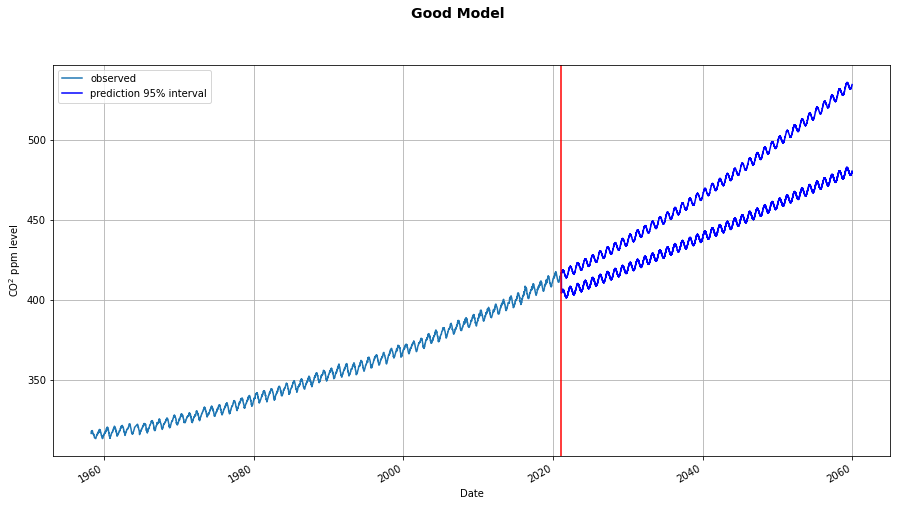

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()

fig.suptitle('Good Model', fontsize=14, fontweight='bold')
# Observed data
df.plot('date', 'level_ppm', ax=ax, grid=True, label='observed')

# 95% confidence interval lower and upper bounds
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], good_prediction_interval[0,1:])),
    'b-', label='prediction 95% interval')
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], good_prediction_interval[1,1:])),
    'b-')

# Model
model_predictions = good_c0 + good_c1*np.exp(good_c2 * to_predict*stan_data['scalingFactor']) + good_c3 * np.cos(2 * np.pi * to_predict / 365.25 + good_c4)
# ax.plot(to_predict_dates, model_predictions, label="Model")

# Last observed date line
ax.axvline(max(df['date']), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('CO$^2$ ppm level')
ax.legend()